## Importação e Preparação da base

In [1]:
# %%capture
# !pip install scikit-optimize
# !pip install openml
# !pip install optuna
# !pip install neupy
# !pip install --upgrade neupy
# !pip install --upgrade theano
# !pip install imbalanced-learn
# !pip install memory_profiler

In [6]:
# Verificação de pacotes
import sys
import subprocess
import pkg_resources

# Função para instalar pacotes, se necessário
def install_package(package):
    try:
        # Verificar se o pacote já está instalado
        dist = pkg_resources.get_distribution(package)
        print(f"'{package}' já está instalado: versão {dist.version}")
    except pkg_resources.DistributionNotFound:
        # Instalar o pacote, se não estiver instalado
        print(f"Instalando '{package}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Lista de pacotes necessários
# Nota: NumPy é forçado para uma versão compatível antes de outras dependências
base_packages = [
    "numpy==1.24",
    "numba==0.57.1"  # Forçar versão compatível com SHAP e Numba
]
other_packages = [
    "scikit-optimize",
    "xgboost",
    "openml",
    "optuna",
    "imbalanced-learn",
    "openpyxl",
    "memory_profiler",
    "lightgbm",
    "GPUtil",
    "psutil",
    "seaborn",
    "shap",
    "lime",
]

# Verificar se está no Google Colab
try:
    import google.colab
    is_colab = True
    print("Detectado ambiente Google Colab.")
except ImportError:
    is_colab = False
    print("Ambiente local detectado.")

# Instalar pacotes de base primeiro (para evitar conflitos)
print("Instalando pacotes base...")
for package in base_packages:
    install_package(package)

# Instalar outros pacotes
print("Instalando outros pacotes...")
for package in other_packages:
    if is_colab or package not in ["neupy", "theano"]:  # 'neupy' e 'theano' apenas em ambiente local
        install_package(package)

# Atualizar pacotes específicos
if not is_colab:
    print("Atualizando 'neupy' e 'theano' no ambiente local...")
    # Atualizar NeuPy
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "neupy"])
    # Atualizar Theano
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "theano"])


Ambiente local detectado.
Instalando pacotes base...
'numpy==1.24' já está instalado: versão 1.24.0
Instalando 'numba==0.57.1'...
Instalando outros pacotes...
'scikit-optimize' já está instalado: versão 0.10.2
'xgboost' já está instalado: versão 2.1.3
'openml' já está instalado: versão 0.15.0
'optuna' já está instalado: versão 4.1.0
'imbalanced-learn' já está instalado: versão 0.12.4
'openpyxl' já está instalado: versão 3.1.5
'memory_profiler' já está instalado: versão 0.61.0
'lightgbm' já está instalado: versão 4.5.0
'GPUtil' já está instalado: versão 1.4.0
'psutil' já está instalado: versão 6.1.0
'seaborn' já está instalado: versão 0.13.2
'shap' já está instalado: versão 0.46.0
'lime' já está instalado: versão 0.2.0.1
Atualizando 'neupy' e 'theano' no ambiente local...


In [7]:
%%capture
import pandas as pd
from scipy.io import arff
import openml
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Definir o ID do dataset no OpenML
dataset_id = 722

# Carregar o dataset diretamente do OpenML
dataset = openml.datasets.get_dataset(dataset_id)
data = dataset.get_data()[0]  # Pega o DataFrame completo

# Remove colunas onde todos os valores são zero: [f10-f12] e [f34-f48]
data = data.loc[:, (data != 0).any(axis=0)]

In [9]:
data.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f13', 'f14',
       'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24',
       'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33',
       'binaryClass'],
      dtype='object')

In [10]:
# prompt: quantidade de atributos

import pandas as pd

# Assuming 'data' is your pandas DataFrame
num_attributes = len(data.columns) - 1
print(f"Número de features: {num_attributes}")

Número de features: 30


## Utilizando ADASYN

In [11]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
import pandas as pd

# Definir a variável alvo
target_column = 'binaryClass'
X = data.drop(columns=[target_column])
y = data[target_column]

# Supondo que y tenha as classes 'N' e 'P' como strings
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Converte as classes para números (0 e 1)


# Dividir os dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definir o StratifiedKFold com 10 folds para garantir a estratificação nas validações cruzadas
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Identificar colunas numéricas e ajustar o tipo de dado para float64
numeric_features = X_train.select_dtypes(include=['uint8']).columns
X_train[numeric_features] = X_train[numeric_features].astype('float64')
X_test[numeric_features] = X_test[numeric_features].astype('float64')

# Substituir valores ausentes pela média em cada coluna numérica
X_train[numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].mean())
X_test[numeric_features] = X_test[numeric_features].fillna(X_train[numeric_features].mean())

# Aplicar transformação (padronização) nas colunas numéricas
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Aplicar ADASYN para balancear as classes no conjunto de treino
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Agora X_train_resampled e y_train_resampled estão prontos para uso em modelos com 10-fold cross-validation


## Comparativo ADASYN

<Figure size 640x480 with 0 Axes>

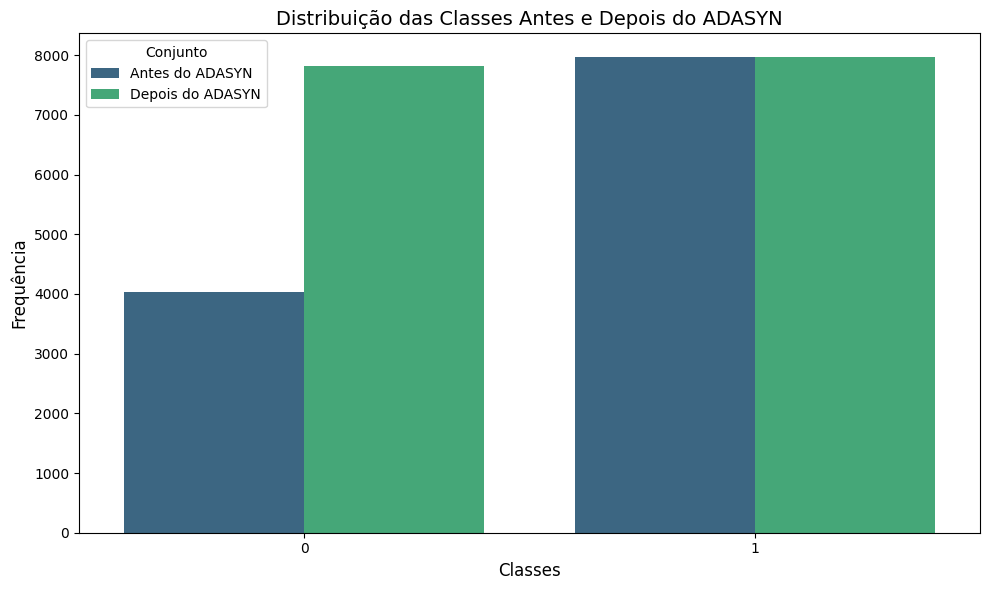

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Função para plotar a distribuição das classes
def plot_class_distribution(y_before, y_after, labels=['Antes do ADASYN', 'Depois do ADASYN']):
    """
    Plota a distribuição das classes antes e depois do balanceamento com ADASYN.
    """
    # Contar as classes antes e depois
    class_counts_before = pd.Series(y_before).value_counts().sort_index()
    class_counts_after = pd.Series(y_after).value_counts().sort_index()

    # Criar DataFrame para plotagem
    df = pd.DataFrame({
        'Classes': class_counts_before.index.tolist() + class_counts_after.index.tolist(),
        'Frequência': class_counts_before.tolist() + class_counts_after.tolist(),
        'Conjunto': [labels[0]] * len(class_counts_before) + [labels[1]] * len(class_counts_after)
    })

    # Plotar distribuição
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Classes', y='Frequência', hue='Conjunto', data=df, palette='viridis')
    plt.title('Distribuição das Classes Antes e Depois do ADASYN', fontsize=14)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)
    plt.legend(title='Conjunto', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Save the plot to a PNG file
plt.savefig('class_distribution.jpeg')

# Comparar antes e depois do ADASYN
plot_class_distribution(y_train, y_train_resampled)




## Início experimento - Variáveis Básicas


In [13]:
# Realizando experimento já considerando X_train_resampled e y_train_resampled
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
# from neupy import algorithms

# Configurar K-Fold com estratificação
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definição básica dos classificadores
knn = KNeighborsClassifier()
lvq = MLPClassifier(solver='sgd', learning_rate='constant', learning_rate_init=0.1, max_iter=100)
tree = DecisionTreeClassifier()
svm = SVC(probability=True)
rf = RandomForestClassifier()
mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(50,))
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(n_estimators=50, max_depth=3, verbose=-1) #verbose=-1 não mostra mensagens de alerta

# Comitê de Redes Neurais Artificiais
ann_ensemble = VotingClassifier(
    estimators=[
        ('mlp_relu', MLPClassifier(activation='relu', hidden_layer_sizes=(50, 20), max_iter=100)),
        ('mlp_tanh', MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 20), max_iter=100)),
        ('mlp_logistic', MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 20), max_iter=100))
    ],
    voting='soft',
    n_jobs=-1  # Paralelização
)

# Comitê Heterogêneo (Stacking)
stacking = StackingClassifier(
    estimators=[
        ('nb', GaussianNB()),  # Modelo rápido e leve
        ('dt', DecisionTreeClassifier(max_depth=3)),  # Árvore de decisão rasa
    ],
    final_estimator=LogisticRegression(max_iter=100),  # Meta-modelo simples
    n_jobs=-1
)

# Dicionário de classificadores inicial:
classifiers = {
    'KNN': knn,             # Bayesian Search
    'SVM': svm,
    'Decision Tree': tree,  # Bayesian Search
    'LVQ': lvq,
    'MLP': mlp,
    'Ensemble Neural Network': ann_ensemble,
    'Stacking': stacking,
    'Random Forest': rf,    #Optuna
    'XGBoost': xgb,         #Optuna
    'LightGBM': lgbm
}

c:\Users\willi\Documents\Projetos\mestrado_mineracao\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tunning Usando Bayesian e Optuna

- Demora em torno de 20 minutos.

In [17]:
# Usando BS e Optuna em dois classificadores diferentes:

# Filtrar warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('sklearn').setLevel(logging.ERROR)

# Configurações para os modelos que costumam gerar warnings
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

# Configurações específicas para XGBoost
from xgboost import set_config
set_config(verbosity=0)

# Espaços de busca para Bayesian Search: KNN e Decision Tree
param_spaces = {
    'KNN': {
        'n_neighbors': (1, 30),
        'weights': ['uniform', 'distance'],
        'p': (1, 2)
    },
    'Decision Tree': {
        'max_depth': (1, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
        'criterion': ['gini', 'entropy']
    }

}

# Avaliar classificadores e buscar hiperparâmetros com BayesSearchCV
results = {}
best_params = {}

for name, clf in classifiers.items():
    if name in param_spaces:
        print(f"Otimizando hiperparâmetros para {name}...")
        bayes_search = BayesSearchCV(
            estimator=clf,
            search_spaces=param_spaces[name],
            n_iter=50,
            cv=kfold,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )

        # Garante que X_train_resampled seja um DataFrame com os nomes de coluna corretos
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

        bayes_search.fit(X_train_resampled, y_train_resampled)
        best_params[name] = bayes_search.best_params_
        clf = bayes_search.best_estimator_
        print(f"Melhores parâmetros para {name}: {bayes_search.best_params_}\n")

#Optuna para RF e XGB

# Funções de objetivo para Optuna
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    return cross_val_score(clf, X_train_resampled, y_train_resampled, cv=kfold, scoring="accuracy").mean()

def xgb_objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)

    # Encode the target variable to numeric values
    le = LabelEncoder()
    y_train_resampled_encoded = le.fit_transform(y_train_resampled)

    clf = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators,
                        max_depth=max_depth, use_label_encoder=False, eval_metric='logloss')
    return cross_val_score(clf, X_train_resampled, y_train_resampled_encoded, cv=kfold, scoring="accuracy").mean()

# Otimização com Optuna
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=5)
classifiers['Random Forest'] = RandomForestClassifier(**rf_study.best_trial.params)
print("Melhores hiperparâmetros para Random Forest:", rf_study.best_trial.params)

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=5)
classifiers['XGBoost'] = XGBClassifier(**xgb_study.best_trial.params, use_label_encoder=False, eval_metric='logloss')
print("Melhores hiperparâmetros para XGBoost:", xgb_study.best_trial.params)

Otimizando hiperparâmetros para KNN...
Melhores parâmetros para KNN: OrderedDict([('n_neighbors', 1), ('p', 1), ('weights', 'uniform')])

Otimizando hiperparâmetros para Decision Tree...


[I 2024-11-29 19:48:03,197] A new study created in memory with name: no-name-826eff76-710c-478d-a669-0fbd49028c59


Melhores parâmetros para Decision Tree: OrderedDict([('criterion', 'entropy'), ('max_depth', 23), ('min_samples_leaf', 1), ('min_samples_split', 2)])



[I 2024-11-29 19:48:17,452] Trial 0 finished with value: 0.8992910354614712 and parameters: {'n_estimators': 193, 'max_depth': 3}. Best is trial 0 with value: 0.8992910354614712.
[I 2024-11-29 19:48:34,052] Trial 1 finished with value: 0.9163927932440276 and parameters: {'n_estimators': 184, 'max_depth': 4}. Best is trial 1 with value: 0.9163927932440276.
[I 2024-11-29 19:48:37,421] Trial 2 finished with value: 0.9312780786479065 and parameters: {'n_estimators': 27, 'max_depth': 6}. Best is trial 2 with value: 0.9312780786479065.
[I 2024-11-29 19:48:44,445] Trial 3 finished with value: 0.9151254463887959 and parameters: {'n_estimators': 77, 'max_depth': 4}. Best is trial 2 with value: 0.9312780786479065.
[I 2024-11-29 19:48:53,656] Trial 4 finished with value: 0.9137323200337766 and parameters: {'n_estimators': 101, 'max_depth': 4}. Best is trial 2 with value: 0.9312780786479065.
[I 2024-11-29 19:48:53,658] A new study created in memory with name: no-name-2c764674-3909-4499-9c1e-2380e8

Melhores hiperparâmetros para Random Forest: {'n_estimators': 27, 'max_depth': 6}


[I 2024-11-29 19:49:02,484] Trial 0 finished with value: 0.984354860330173 and parameters: {'learning_rate': 0.010109829632956214, 'n_estimators': 162, 'max_depth': 10}. Best is trial 0 with value: 0.984354860330173.
[I 2024-11-29 19:49:08,434] Trial 1 finished with value: 0.9374208058717434 and parameters: {'learning_rate': 0.0010674513804083954, 'n_estimators': 273, 'max_depth': 5}. Best is trial 0 with value: 0.984354860330173.
[I 2024-11-29 19:49:13,559] Trial 2 finished with value: 0.9248158859427964 and parameters: {'learning_rate': 0.006245154718456152, 'n_estimators': 327, 'max_depth': 3}. Best is trial 0 with value: 0.984354860330173.
[I 2024-11-29 19:49:36,831] Trial 3 finished with value: 0.9728270527864533 and parameters: {'learning_rate': 0.0013207537282401275, 'n_estimators': 453, 'max_depth': 8}. Best is trial 0 with value: 0.984354860330173.
[I 2024-11-29 19:49:40,389] Trial 4 finished with value: 0.9800475345371884 and parameters: {'learning_rate': 0.05372742901459394,

Melhores hiperparâmetros para XGBoost: {'learning_rate': 0.010109829632956214, 'n_estimators': 162, 'max_depth': 10}


## Resumo Melhores Parâmetros

In [14]:
# Obter os parâmetros do classificador e remover os que têm valor None
xgb_clean_params = {k: v for k, v in classifiers['XGBoost'].get_params().items() if v is not None}

# Criar um novo classificador com os parâmetros limpos
cleaned_xgb = XGBClassifier(**xgb_clean_params)

print("Parâmetros do XGBoost sem valores None:")
print(xgb_clean_params)

Parâmetros do XGBoost sem valores None:
{'objective': 'binary:logistic', 'enable_categorical': False, 'eval_metric': 'logloss', 'missing': nan, 'use_label_encoder': False}


In [15]:
# Converter parâmetros otimizados para inicializar os classificadores
best_classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=1, p=1, weights='uniform'), # Otimizado com Bayesian Search
    'SVM': svm,  # Nenhuma otimização aplicada
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=36, min_samples_leaf=1, min_samples_split=2), # Otimizado com Bayesian Search
    'LVQ': lvq,  # Nenhuma otimização aplicada
    'MLP': mlp,  # Nenhuma otimização aplicada
    'Ensemble Neural Network': ann_ensemble,  # Nenhuma otimização aplicada
    'Stacking': stacking,  # Nenhuma otimização aplicada
    'Random Forest': RandomForestClassifier(max_depth=28, n_estimators=97), # Otimizado com Optuna
    'XGBoost': XGBClassifier(objective='binary:logistic', enable_categorical=False, eval_metric='logloss',
                             learning_rate=0.09504317284612004, max_depth=6, n_estimators=188),  # Otimizado com Optuna
    'LightGBM': lgbm # Nenhuma otimização aplicada
}

# Mostrar os melhores parâmetros para os classificadores otimizados
print("Classificadores com os melhores parâmetros:")

for name, model in best_classifiers.items():
  print(f"{name}: {model}")

Classificadores com os melhores parâmetros:
KNN: KNeighborsClassifier(n_neighbors=1, p=1)
SVM: SVC(probability=True)
Decision Tree: DecisionTreeClassifier(criterion='entropy', max_depth=36)
LVQ: MLPClassifier(learning_rate_init=0.1, max_iter=100, solver='sgd')
MLP: MLPClassifier(hidden_layer_sizes=(50,), max_iter=100)
Ensemble Neural Network: VotingClassifier(estimators=[('mlp_relu',
                              MLPClassifier(hidden_layer_sizes=(50, 20),
                                            max_iter=100)),
                             ('mlp_tanh',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=(50, 20),
                                            max_iter=100)),
                             ('mlp_logistic',
                              MLPClassifier(activation='logistic',
                                            hidden_layer_sizes=(50, 20),
                                            max_iter=100

## Avaliando os modelos após Tunning

- Demora em torno de 20 minutos
*   Avalia os modelos após o tunning usando Optuna e Bayesian Search (dicionário anterior)
*   Calcula o tempo de execução e consumo de memória para cada modelo.



In [51]:
# Definição das funções
import time
from memory_profiler import memory_usage
import psutil
import GPUtil
import warnings
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_validate

# Filtrar warnings
warnings.filterwarnings('ignore')

# Definindo os classificadores otimizados com os melhores parâmetros
classifiers = best_classifiers

def calculate_acsa(y_true, y_pred):
    classes = np.unique(y_true)
    class_accuracies = [
        accuracy_score(y_true[y_true == c], y_pred[y_true == c]) for c in classes
    ]
    return np.mean(class_accuracies)

def get_gpu_usage():
    """
    Obtém o uso da GPU se disponível.
    """
    gpus = GPUtil.getGPUs()
    if not gpus:
        return 0  # Sem GPU disponível
    return sum([gpu.load for gpu in gpus]) / len(gpus) * 100  # Média de uso em %

def evaluate_model(model, X, y, kfold):
    """
    Avalia o modelo com métricas de desempenho e recursos computacionais (tempo, memória, CPU e GPU).
    """

    # Converter para array numpy se for DataFrame/Series
    X_numpy = X.values if hasattr(X, 'values') else X
    y_numpy = y.values if hasattr(y, 'values') else y

    # Iniciar medição de tempo, memória, CPU e GPU
    start_time = time.time()
    mem_usage_start = memory_usage()[0]
    cpu_start = psutil.cpu_percent(interval=None)
    gpu_start = get_gpu_usage()

    # Usar cross_validate para calcular accuracy, f1 e recall em uma única chamada
    scoring = ['accuracy', 'f1', 'recall']
    scores = cross_validate(model, X_numpy, y_numpy, cv=kfold, scoring=scoring, return_estimator=True)

    # Calcular tempo, memória, CPU e GPU após validação cruzada
    training_time = time.time() - start_time
    mem_usage_end = memory_usage()[0]
    memory_consumed = mem_usage_end - mem_usage_start
    cpu_end = psutil.cpu_percent(interval=None)
    gpu_end = get_gpu_usage()

    # Calcular média de uso de CPU e GPU
    cpu_usage = (cpu_end + cpu_start) / 2
    gpu_usage = (gpu_end + gpu_start) / 2

    # Métricas médias da validação cruzada
    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()
    recall = scores['test_recall'].mean()

    # Cálculo do ACSA manualmente
    acsa_scores = []
    for estimator, (train_idx, val_idx) in zip(scores['estimator'], kfold.split(X_numpy, y_numpy)):
        X_val_fold = X_numpy[val_idx]
        y_val_fold = y_numpy[val_idx]
        y_pred_fold = estimator.predict(X_val_fold)
        acsa_scores.append(calculate_acsa(y_val_fold, y_pred_fold))
    acsa = np.mean(acsa_scores)

    # Ajustar modelo nos dados completos e calcular a matriz de confusão
    model.fit(X_numpy, y_numpy)
    y_pred = model.predict(X_numpy)
    conf_matrix = confusion_matrix(y_numpy, y_pred)

    return accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage


In [24]:
# Uso do código
results = {}
for name, clf in best_classifiers.items():
    # Avaliar desempenho do classificador
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train_resampled, y_train_resampled, kfold)

    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'ACSA': acsa,
        'Training Time (s)': training_time,
        'Memory Usage (MB)': memory_consumed,
        'CPU Usage (%)': cpu_usage,
        'GPU Usage (%)': gpu_usage,
        'Confusion Matrix': conf_matrix
    }

    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ACSA: {acsa:.4f}, Training Time (s): {training_time:.4f}, Memory Usage (MB): {memory_consumed:.4f}, CPU Usage (%): {cpu_usage:.2f}, GPU Usage (%): {gpu_usage:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")


KNN - Accuracy: 0.9791, F1 Score: 0.9789, Recall: 0.9592, ACSA: 0.9793, Training Time (s): 2.7135, Memory Usage (MB): 35.5039, CPU Usage (%): 19.75, GPU Usage (%): 0.00
Confusion Matrix:
[[7821    0]
 [   0 7967]]

SVM - Accuracy: 0.9680, F1 Score: 0.9673, Recall: 0.9386, ACSA: 0.9683, Training Time (s): 239.5132, Memory Usage (MB): -158.7734, CPU Usage (%): 29.15, GPU Usage (%): 0.00
Confusion Matrix:
[[7814    7]
 [ 461 7506]]

Decision Tree - Accuracy: 0.9844, F1 Score: 0.9845, Recall: 0.9803, ACSA: 0.9845, Training Time (s): 1.8928, Memory Usage (MB): 3.8828, CPU Usage (%): 14.60, GPU Usage (%): 0.00
Confusion Matrix:
[[7821    0]
 [   0 7967]]

LVQ - Accuracy: 0.9935, F1 Score: 0.9936, Recall: 0.9908, ACSA: 0.9936, Training Time (s): 68.5304, Memory Usage (MB): -36.6211, CPU Usage (%): 10.35, GPU Usage (%): 0.00
Confusion Matrix:
[[7817    4]
 [  22 7945]]

MLP - Accuracy: 0.9902, F1 Score: 0.9902, Recall: 0.9843, ACSA: 0.9902, Training Time (s): 40.8061, Memory Usage (MB): 1.2891

In [21]:
# Exibir resultados
import pandas as pd
df_results = pd.DataFrame.from_dict(results, orient='index')

# Salvar em Excel
df_results.to_excel('results_with_cost_benefit.xlsx')

# Apresentar
df_results

,Accuracy,F1 Score,Recall,ACSA,Training Time (s),Memory Usage (MB),CPU Usage (%),GPU Usage (%),Confusion Matrix
KNN,0.979098,0.978856,0.959209,0.979285,4.140716,35.933594,44.90,0.0,"[[7821, 0], [0, 7967]]"
SVM,0.968014,0.967327,0.938623,0.968288,247.687245,55.996094,28.25,0.0,"[[7814, 7], [461, 7506]]"
Decision Tree,0.983975,0.984058,0.980167,0.984011,1.791338,2.535156,14.75,0.0,"[[7821, 0], [0, 7967]]"
LVQ,0.994046,0.994080,0.990837,0.994076,92.532249,-47.816406,7.00,0.0,"[[7816, 5], [20, 7947]]"
MLP,0.990309,0.990342,0.984687,0.990362,46.456718,28.582031,20.85,0.0,"[[7813, 8], [61, 7906]]"
Ensemble Neural Network,0.994236,0.994266,0.990336,0.994273,124.469784,-121.117188,21.70,0.0,"[[7820, 1], [16, 7951]]"
Stacking,0.886687,0.889236,0.902975,0.886532,4.123944,-16.515625,27.70,0.0,"[[6682, 1139], [598, 7369]]"
Random Forest,0.991069,0.991104,0.986192,0.991114,22.565561,59.781250,20.65,0.0,"[[7821, 0], [0, 7967]]"
XGBoost,0.990816,0.990845,0.985313,0.990867,5.662494,61.640625,54.05,0.0,"[[7819, 2], [15, 7952]]"
LightGBM,0.945718,0.944180,0.910131,0.946052,1.145050,1.058594,65.15,0.0,"[[7712, 109], [709, 7258]]"


## Comparando Antes e Depois ADASYN

Comparando os desempenhos do treinamento dos classificadores KNN e Árvore de Decisão antes e depois de aplicar o balanceamento de classes usando a técnica ADASYN.

In [52]:
# Classificadores após o Tunning

adasyn_classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=1, p=1, weights='uniform'), # Otimizado com Bayesian Search
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=36, min_samples_leaf=1, min_samples_split=2), # Otimizado com Bayesian Search
    'MLP': mlp  # Nenhuma otimização aplicada
}

# Dicionário para armazenar os resultados
results_adasyn = {
    'Classifier': [],
    'Phase': [],  # 'Antes' ou 'Depois' o balanceamento
    'Accuracy': [],
    'F1 Score': [],
    'Recall': [],
    'ACSA': []
}

# Iterando no dicionário de classificadores
for name, clf in adasyn_classifiers.items():
    # Avaliação antes do balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train, y_train, kfold)
    results_adasyn['Classifier'].append(name)
    results_adasyn['Phase'].append('Antes')
    results_adasyn['Accuracy'].append(accuracy)
    results_adasyn['F1 Score'].append(f1)
    results_adasyn['Recall'].append(recall)
    results_adasyn['ACSA'].append(acsa)

    # Avaliação após o balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train_resampled, y_train_resampled, kfold)
    results_adasyn['Classifier'].append(name)
    results_adasyn['Phase'].append('Depois')
    results_adasyn['Accuracy'].append(accuracy)
    results_adasyn['F1 Score'].append(f1)
    results_adasyn['Recall'].append(recall)
    results_adasyn['ACSA'].append(acsa)

# Conversão para um DataFrame
df_results_adasyn = pd.DataFrame(results_adasyn)

# Exibição do DataFrame
print(df_results_adasyn)

# Salvar o DataFrame em um arquivo Excel
df_results_adasyn.to_excel('results_adasyn_comparison.xlsx', index=False)


      Classifier   Phase  Accuracy  F1 Score    Recall      ACSA
0            KNN   Antes  0.964083  0.972762  0.966113  0.963098
1            KNN  Depois  0.979098  0.978856  0.959209  0.979285
2  Decision Tree   Antes  0.978917  0.984123  0.983934  0.976472
3  Decision Tree  Depois  0.985305  0.985389  0.981800  0.985338
4            MLP   Antes  0.988250  0.991168  0.992720  0.986071
5            MLP  Depois  0.989993  0.990028  0.984561  0.990043


## Desempenho Treino e Teste após Tunning

- Demora 20 minutos

In [29]:
# Converter parâmetros otimizados para inicializar os classificadores
best_classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=1, p=1, weights='uniform'), # Otimizado com Bayesian Search
    'SVM': svm,  # Nenhuma otimização aplicada
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=36, min_samples_leaf=1, min_samples_split=2), # Otimizado com Bayesian Search
    'LVQ': lvq,  # Nenhuma otimização aplicada
    'MLP': mlp,  # Nenhuma otimização aplicada
    'Ensemble Neural Network': ann_ensemble,  # Nenhuma otimização aplicada
    'Stacking': stacking,  # Nenhuma otimização aplicada
    'Random Forest': RandomForestClassifier(max_depth=28, n_estimators=97), # Otimizado com Optuna
    'XGBoost': XGBClassifier(objective='binary:logistic', enable_categorical=False, eval_metric='logloss',
                             learning_rate=0.09504317284612004, max_depth=6, n_estimators=188),  # Otimizado com Optuna
    'LightGBM': lgbm # Nenhuma otimização aplicada
}

# Configurar K-Fold com estratificação
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados
results_train_teste = {
    'Classifier': [],
    'Etapa': [],  # 'Antes' ou 'Depois' o balanceamento
    'Accuracy': [],
    'F1 Score': [],
    'Recall': [],
    'ACSA': []
}

# Iterando no dicionário de classificadores
for name, clf in best_classifiers.items():
    # Avaliação antes do balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train_resampled, y_train_resampled, kfold)
    results_train_teste['Classifier'].append(name)
    results_train_teste['Etapa'].append('Treinamento')
    results_train_teste['Accuracy'].append(accuracy)
    results_train_teste['F1 Score'].append(f1)
    results_train_teste['Recall'].append(recall)
    results_train_teste['ACSA'].append(acsa)

    # Avaliação após o balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_test, y_test, kfold)
    results_train_teste['Classifier'].append(name)
    results_train_teste['Etapa'].append('Teste')
    results_train_teste['Accuracy'].append(accuracy)
    results_train_teste['F1 Score'].append(f1)
    results_train_teste['Recall'].append(recall)
    results_train_teste['ACSA'].append(acsa)

# Conversão para um DataFrame
df_results_train_teste = pd.DataFrame(results_train_teste)

# Exibição do DataFrame
print(df_results_train_teste)

# Salvar o DataFrame em um arquivo Excel
df_results_train_teste.to_excel('results_train_teste_comparison.xlsx', index=False)



                 Classifier        Etapa  Accuracy  F1 Score    Recall  \
0                       KNN  Treinamento  0.979098  0.978856  0.959209   
1                       KNN        Teste  0.942667  0.956500  0.950807   
2                       SVM  Treinamento  0.968014  0.967327  0.938623   
3                       SVM        Teste  0.948000  0.961662  0.980925   
4             Decision Tree  Treinamento  0.984609  0.984690  0.980921   
5             Decision Tree        Teste  0.962333  0.971685  0.973379   
6                       LVQ  Treinamento  0.994490  0.994522  0.991339   
7                       LVQ        Teste  0.978667  0.984041  0.988457   
8                       MLP  Treinamento  0.989803  0.989829  0.983558   
9                       MLP        Teste  0.973000  0.979826  0.986952   
10  Ensemble Neural Network  Treinamento  0.994173  0.994204  0.990336   
11  Ensemble Neural Network        Teste  0.974333  0.980810  0.987952   
12                 Stacking  Treinamen

## Amostra para análise Estatística

In [ ]:
import warnings
import logging
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from xgboost import set_config

# Filtrar warnings
warnings.filterwarnings('ignore')
logging.getLogger('sklearn').setLevel(logging.ERROR)
os.environ['PYTHONWARNINGS'] = 'ignore'
set_config(verbosity=0)

# Definindo os classificadores otimizados com os melhores parâmetros
classifiers = best_classifiers

def calculate_acsa(y_true, y_pred):
    """Calcula o Average Class-Specific Accuracy (ACSA)."""
    classes = np.unique(y_true)
    class_accuracies = [
        accuracy_score(y_true[y_true == c], y_pred[y_true == c]) for c in classes
    ]
    return np.mean(class_accuracies)

def evaluate_model(model, X, y, kfold, n_samples=10):
    """
    Avalia o modelo usando validação cruzada múltiplas vezes.
    Args:
    model: Modelo de classificação
    X: Features (DataFrame ou array)
    y: Target (Series ou array)
    kfold: Objeto de validação cruzada
    n_samples: Número de iterações de avaliação
    """
    # Converter para numpy arrays se necessário
    X_numpy = X.values if hasattr(X, 'values') else np.array(X)
    y_numpy = y.values if hasattr(y, 'values') else np.array(y)
    results = {
        'Accuracy': [],
        'F1 Score': [],
        'Recall': [],
        'ACSA': [],
        'Confusion Matrix': []
    }
    for sample in range(n_samples):
        try:
            # Realizando a validação cruzada
            scores = cross_validate(
                model,
                X_numpy,
                y_numpy,
                cv=kfold,
                scoring=['accuracy', 'f1', 'recall'],
                return_estimator=True,
                n_jobs=-1 # Usar todos os cores disponíveis
            )
            # Métricas médias da validação cruzada
            results['Accuracy'].append(scores['test_accuracy'].mean())
            results['F1 Score'].append(scores['test_f1'].mean())
            results['Recall'].append(scores['test_recall'].mean())
            # Cálculo do ACSA
            acsa_scores = []
            for estimator, (_, val_idx) in zip(scores['estimator'], kfold.split(X_numpy, y_numpy)):
                X_val = X_numpy[val_idx]
                y_val = y_numpy[val_idx]
                y_pred = estimator.predict(X_val)
                acsa_scores.append(calculate_acsa(y_val, y_pred))
            results['ACSA'].append(np.mean(acsa_scores))
            # Matriz de confusão usando o último modelo ajustado
            model.fit(X_numpy, y_numpy)
            y_pred_final = model.predict(X_numpy)
            results['Confusion Matrix'].append(confusion_matrix(y_numpy, y_pred_final))
        except Exception as e:
            print(f"Erro na amostra {sample}: {str(e)}")
            continue
    return results

def print_results(results_dict):
    """Imprime os resultados de forma organizada e gera DataFrames."""
    metrics_dfs = {metric: pd.DataFrame() for metric in ['Accuracy', 'F1 Score', 'Recall', 'ACSA']}

    for name, metrics in results_dict.items():
        print(f"\n{'='*50}")
        print(f"Resultados para {name}:")
        print(f"{'='*50}")
        # Métricas numéricas
        for metric in ['Accuracy', 'F1 Score', 'Recall', 'ACSA']:
            values = metrics[metric]
            if values: # Verifica se há valores
                print(f"\n{metric}:")
                for value in values:
                    print(f" {value:.4f}")
                # Adiciona os resultados ao DataFrame correspondente
                metrics_dfs[metric][name] = values

    # Retorna os DataFrames
    return metrics_dfs

def save_to_excel(metrics_dfs, filename='metrics_results.xlsx'):
    """Salva os DataFrames em uma planilha Excel, com cada aba representando uma métrica distinta."""
    with pd.ExcelWriter(filename) as writer:
        for metric, df in metrics_dfs.items():
            df.to_excel(writer, sheet_name=metric)

# Uso do código
if __name__ == "__main__":
    # Definindo a validação cruzada
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
    # Inicializando resultados
    results = {}
    # Avaliando cada classificador
    for name, clf in classifiers.items():
        print(f"\nAvaliando {name}...")
        results[name] = evaluate_model(
            clf,
            X_train_resampled,
            y_train_resampled,
            kfold,
            n_samples=10
        )
    # Imprimindo resultados e gerando DataFrames
    metrics_dfs = print_results(results)

    # Salvando os DataFrames em uma planilha Excel
    save_to_excel(metrics_dfs)

    # Exemplo de como acessar os DataFrames
    accuracy_df = metrics_dfs['Accuracy']
    f1_score_df = metrics_dfs['F1 Score']
    recall_df = metrics_dfs['Recall']
    acsa_df = metrics_dfs['ACSA']

In [ ]:
save_to_excel(metrics_dfs)

## Teste de Estresse novos dados

### Gerando dados sintéticos

In [17]:
# Gerar Dados Sintéticos
from sklearn.datasets import make_classification

def generate_synthetic_data(n_samples=200, n_features=30, n_informative=10, n_redundant=5, feature_names=None, random_state=42):
    """
    Gera dados sintéticos para teste de estresse de classificadores.

    Args:
    n_samples (int): Número de amostras.
    n_features (int): Número total de características.
    n_informative (int): Número de características informativas.
    n_redundant (int): Número de características redundantes.
    feature_names (list): Lista de nomes para as colunas geradas.
    random_state (int): Semente para reprodutibilidade.

    Returns:
    X_synthetic (DataFrame): Dados de entrada sintéticos.
    y_synthetic (Series): Classes correspondentes.
    """
    # Gerar dados
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=2,
        flip_y=0.1,  # Introduzir ruído
        class_sep=0.8,  # Reduzir separação entre classes para maior desafio
        random_state=random_state
    )

    # Converter para DataFrame
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(1, n_features + 1)]
    X_synthetic = pd.DataFrame(X, columns=feature_names)
    y_synthetic = pd.Series(y, name="target")

    return X_synthetic, y_synthetic

# Gerar dados sintéticos com os mesmos nomes de colunas dos dados de treinamento
X_synthetic, y_synthetic = generate_synthetic_data(
    n_samples=200,
    n_features=X_train_resampled.shape[1],
    n_informative=10,
    n_redundant=5,
    feature_names=X_train_resampled.columns.tolist()
)

# Visualizar os dados gerados
print("Exemplo de dados sintéticos:")
print(X_synthetic.head())
print("\nDistribuição das classes:")
print(y_synthetic.value_counts())


Exemplo de dados sintéticos:
         f1        f2        f3        f4        f5        f6        f7  \
0 -3.269112  3.513117 -0.529201 -0.932867  0.536414 -2.790119 -0.869287   
1  4.321401 -1.526260 -0.692351 -1.781169 -0.273729 -1.907548 -0.659039   
2 -2.211783 -4.441093  0.051198 -1.974622 -0.213457  0.847032 -0.501784   
3 -4.923394  4.344866 -2.132596  0.117327  1.452617 -1.079046  1.012637   
4  4.372500 -2.568167 -0.385022 -1.694910 -0.936506 -0.958699  0.382989   

         f8        f9       f13  ...       f24       f25       f26       f27  \
0 -3.719915 -0.211384  1.033881  ...  2.644457  0.907962  0.123480 -0.798858   
1  1.883620  0.392634 -0.014270  ...  1.787822  0.097827  0.436006 -0.417870   
2 -1.866255 -0.048089  0.496199  ...  2.296966  0.511500  1.935154  0.051362   
3 -1.152980  1.352203 -0.916321  ...  3.351479 -0.140375  0.307613  0.959610   
4  0.100247 -0.606865 -0.667780  ... -4.048788 -0.187329 -2.238231 -1.220818   

        f28       f29       f30       f

### Teste de Estresse com os dados Sintéticos

In [18]:
from sklearn.exceptions import NotFittedError
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def stress_test_models(best_classifiers, X_synthetic, y_synthetic, X_train=None, y_train=None, export_excel=True):
    """
    Realiza testes de estresse nos modelos e gera relatório em Excel com 3 abas, incluindo a métrica ACSa.
    
    Parameters:
    -----------
    best_classifiers : dict
        Dicionário contendo os modelos treinados
    X_synthetic : array-like
        Dados sintéticos de features
    y_synthetic : array-like
        Labels sintéticos correspondentes
    X_train : array-like, optional
        Dados de treinamento para treinar o modelo caso não esteja ajustado.
    y_train : array-like, optional
        Labels de treinamento para treinar o modelo caso não esteja ajustado.
    export_excel : bool, optional
        Se True, exporta os resultados para um arquivo Excel.
    """
    print("Iniciando teste de estresse nos modelos...")

    # Dicionários para resultados
    results_geral = {
        'Modelo': [],
        'Acurácia': [],
        'ACSa': [],
        'Precisão': [],
        'Recall': [],
        'F1-Score': [],
        'Total_Amostras': []
    }

    results_classe_0 = {
        'Modelo': [],
        'Precisão': [],
        'Recall': [],
        'F1-Score': [],
        'Quantidade_Amostras': [],
        'Proporção_Amostras': []
    }

    results_classe_1 = {
        'Modelo': [],
        'Precisão': [],
        'Recall': [],
        'F1-Score': [],
        'Quantidade_Amostras': [],
        'Proporção_Amostras': []
    }

    for nome_modelo, modelo in best_classifiers.items():
        print(f"Testando modelo: {nome_modelo}...")
        try:
            # Verifica se o modelo está treinado
            y_pred = modelo.predict(X_synthetic)
        except NotFittedError:
            if X_train is not None and y_train is not None:
                print(f"O modelo {nome_modelo} não está ajustado. Treinando com dados fornecidos...")
                modelo.fit(X_train, y_train)
                y_pred = modelo.predict(X_synthetic)
            else:
                print(f"O modelo {nome_modelo} não está ajustado e não foram fornecidos dados de treinamento.")
                continue

        # Métricas gerais
        accuracy = accuracy_score(y_synthetic, y_pred)
        precision = precision_score(y_synthetic, y_pred, average='weighted')
        recall = recall_score(y_synthetic, y_pred, average='weighted')
        f1 = f1_score(y_synthetic, y_pred, average='weighted')

        # Métricas por classe
        precision_per_class = precision_score(y_synthetic, y_pred, average=None)
        recall_per_class = recall_score(y_synthetic, y_pred, average=None)
        f1_per_class = f1_score(y_synthetic, y_pred, average=None)
        amostras_por_classe = dict(zip(*np.unique(y_synthetic, return_counts=True)))
        total_amostras = len(y_synthetic)

        # Cálculo da ACSa
        acsa = sum(
            (amostras_por_classe.get(classe, 0) / total_amostras) * recall_per_class[idx]
            for idx, classe in enumerate([0, 1])
        )

        # Adicionar resultados gerais
        results_geral['Modelo'].append(nome_modelo)
        results_geral['Acurácia'].append(round(accuracy * 100, 2))
        results_geral['ACSa'].append(round(acsa * 100, 2))
        results_geral['Precisão'].append(round(precision * 100, 2))
        results_geral['Recall'].append(round(recall * 100, 2))
        results_geral['F1-Score'].append(round(f1 * 100, 2))
        results_geral['Total_Amostras'].append(total_amostras)

        # Resultados Classe 0
        results_classe_0['Modelo'].append(nome_modelo)
        results_classe_0['Precisão'].append(round(precision_per_class[0] * 100, 2))
        results_classe_0['Recall'].append(round(recall_per_class[0] * 100, 2))
        results_classe_0['F1-Score'].append(round(f1_per_class[0] * 100, 2))
        results_classe_0['Quantidade_Amostras'].append(amostras_por_classe.get(0, 0))
        results_classe_0['Proporção_Amostras'].append(
            round(amostras_por_classe.get(0, 0) / total_amostras * 100, 2)
        )

        # Resultados Classe 1
        results_classe_1['Modelo'].append(nome_modelo)
        results_classe_1['Precisão'].append(round(precision_per_class[1] * 100, 2))
        results_classe_1['Recall'].append(round(recall_per_class[1] * 100, 2))
        results_classe_1['F1-Score'].append(round(f1_per_class[1] * 100, 2))
        results_classe_1['Quantidade_Amostras'].append(amostras_por_classe.get(1, 0))
        results_classe_1['Proporção_Amostras'].append(
            round(amostras_por_classe.get(1, 0) / total_amostras * 100, 2)
        )

    # Criar DataFrames
    df_geral = pd.DataFrame(results_geral).sort_values('Acurácia', ascending=False)
    df_classe_0 = pd.DataFrame(results_classe_0).sort_values('Recall', ascending=False)
    df_classe_1 = pd.DataFrame(results_classe_1).sort_values('Recall', ascending=False)

    print("Testes concluídos.")
    
    # Exportar para Excel
    if export_excel:
        with pd.ExcelWriter('results_stress_test.xlsx', engine='openpyxl') as writer:
            df_geral.to_excel(writer, sheet_name='Geral', index=False)
            df_classe_0.to_excel(writer, sheet_name='Classe_0', index=False)
            df_classe_1.to_excel(writer, sheet_name='Classe_1', index=False)
        print("Resultados exportados para 'results_stress_test.xlsx'.")

    return df_geral, df_classe_0, df_classe_1


stress_test_models(best_classifiers, X_synthetic, y_synthetic, X_train_resampled, y_train_resampled, export_excel=True)

Iniciando teste de estresse nos modelos...
Testando modelo: KNN...
O modelo KNN não está ajustado. Treinando com dados fornecidos...
Testando modelo: SVM...
O modelo SVM não está ajustado. Treinando com dados fornecidos...


c:\Users\willi\Documents\Projetos\mestrado_mineracao\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willi\Documents\Projetos\mestrado_mineracao\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testando modelo: Decision Tree...
O modelo Decision Tree não está ajustado. Treinando com dados fornecidos...
Testando modelo: LVQ...
O modelo LVQ não está ajustado. Treinando com dados fornecidos...


c:\Users\willi\Documents\Projetos\mestrado_mineracao\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Testando modelo: MLP...
O modelo MLP não está ajustado. Treinando com dados fornecidos...


c:\Users\willi\Documents\Projetos\mestrado_mineracao\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Testando modelo: Ensemble Neural Network...
O modelo Ensemble Neural Network não está ajustado. Treinando com dados fornecidos...
Testando modelo: Stacking...
O modelo Stacking não está ajustado. Treinando com dados fornecidos...


c:\Users\willi\Documents\Projetos\mestrado_mineracao\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willi\Documents\Projetos\mestrado_mineracao\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testando modelo: Random Forest...
O modelo Random Forest não está ajustado. Treinando com dados fornecidos...
Testando modelo: XGBoost...
O modelo XGBoost não está ajustado. Treinando com dados fornecidos...
Testando modelo: LightGBM...
O modelo LightGBM não está ajustado. Treinando com dados fornecidos...
Testes concluídos.
Resultados exportados para 'results_stress_test.xlsx'.


(                    Modelo  Acurácia  ACSa  Precisão  Recall  F1-Score  \
 2            Decision Tree      57.0  57.0     59.59    57.0     53.88   
 7            Random Forest      57.0  57.0     61.86    57.0     52.09   
 8                  XGBoost      57.0  57.0     58.33    57.0     55.21   
 3                      LVQ      56.5  56.5     57.41    56.5     55.13   
 4                      MLP      55.5  55.5     56.01    55.5     54.54   
 5  Ensemble Neural Network      55.5  55.5     55.54    55.5     55.41   
 9                 LightGBM      55.0  55.0     55.57    55.0     53.82   
 0                      KNN      51.5  51.5     51.64    51.5     50.46   
 1                      SVM      50.0  50.0     25.00    50.0     33.33   
 6                 Stacking      50.0  50.0     25.00    50.0     33.33   
 
    Total_Amostras  
 2             200  
 7             200  
 8             200  
 3             200  
 4             200  
 5             200  
 9             200  
 0   

## Explainable AI (XAi)

Vamos usar o SHAP para explicar o modelo Random Forest e o LIME para explicar o modelo XGBoost, que são dois dos modelos com bons desepenhos desempenho segundo a planilha "results_with_cost_benefit".

### Exemplo de Explicação com SHAP no KNN

- Utilizamos 30 amostras no SHAP para ganhar tempo e velocidade.
- Com 30 amostras demora 10 minutos.

100%|██████████| 30/30 [10:56<00:00, 21.89s/it]


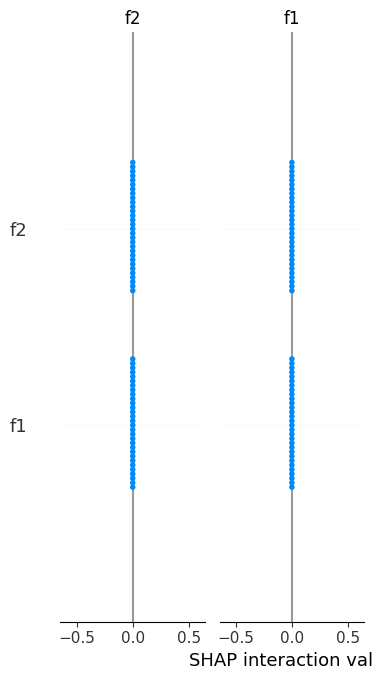

In [46]:
import shap
from sklearn.neighbors import KNeighborsClassifier

# Criar e treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=1, p=1)
knn.fit(X_train_resampled, y_train_resampled)

# Usar um subconjunto menor de dados para o explainer
background = shap.sample(X_train_resampled, 30)  # Amostra menor para melhorar a velocidade
explainer = shap.KernelExplainer(knn.predict_proba, background)

# Calcular os valores SHAP para um subconjunto do conjunto de teste
X_test_subset = shap.sample(X_test, 30)  # Usar um subconjunto do teste
shap_values = explainer.shap_values(X_test_subset)

# Visualizar os valores SHAP
shap.summary_plot(shap_values, X_test_subset)


### Exemplo de Explicação com LIME no XGBoost

In [49]:
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Criar e treinar o modelo XGBoost com os parâmetros especificados
model_xgb = XGBClassifier(n_estimators=188)
model_xgb.fit(X_train_resampled, y_train_resampled)

# Criar o explainer do LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_resampled.values,
    feature_names=X_train_resampled.columns,
    class_names=['N', 'P'],  # Ajuste conforme suas classes
    mode='classification'
)

# Explicar uma previsão específica (por exemplo, a primeira instância do conjunto de teste)
i = 0  # Índice da instância a ser explicada
exp = explainer.explain_instance(X_test.iloc[i].values, model_xgb.predict_proba)

# Gerar a figura com os resultados do LIME
fig = exp.as_pyplot_figure(label=1)  # label=1 para a classe positiva
plt.tight_layout()

# Salvar a figura
plt.savefig('lime_results.png', dpi=300, bbox_inches='tight')

# Mostrar a figura na célula de saída
display(fig)
plt.close()

# Mostrar as características mais importantes
print("Características mais importantes:")
exp.as_list()

[('f7 > -0.17', 0.27566831421468757),
 ('f9 <= -0.23', -0.24191387490672223),
 ('-0.51 < f5 <= -0.02', -0.19103915062299198),
 ('f8 > -0.25', 0.1802652317935608),
 ('-0.21 < f6 <= 0.53', -0.14038283188613804),
 ('f21 <= -0.33', -0.03286149457164773),
 ('f25 > -0.20', -0.03095130678033942),
 ('f27 <= -0.17', 0.03081904735348857),
 ('f22 <= -0.32', 0.027906729980667913),
 ('f24 > -0.22', 0.02680318617097293)]

Este resultado do LIME (Local Interpretable Model-agnostic Explanations) fornece uma explicação local para uma previsão específica feita por um modelo de machine learning. 

Cada linha representa uma característica (feature) e sua contribuição para a previsão do modelo para uma instância particular. 

Vamos analisar os componentes principais:

1) Interpretação das Características

1. **f7 > -0.17** (0.2757): Esta é a característica mais influente. Quando f7 é maior que -0.17, isso aumenta a probabilidade da previsão em aproximadamente 27.57%.

2. **f9 <= -0.23** (-0.2419): A segunda característica mais importante. Quando f9 é menor ou igual a -0.23, isso diminui a probabilidade da previsão em cerca de 24.19%.

3. **-0.51 < f5 <= -0.02** (-0.1910): Quando f5 está entre -0.51 e -0.02, isso reduz a probabilidade da previsão em aproximadamente 19.10%.

4. **f8 > -0.25** (0.1803): Se f8 é maior que -0.25, isso aumenta a probabilidade da previsão em cerca de 18.03%.

5. **-0.21 < f6 <= 0.53** (-0.1404): Quando f6 está entre -0.21 e 0.53, isso diminui a probabilidade da previsão em aproximadamente 14.04%.

2) Características Menos Influentes

As características restantes (f21, f25, f27, f22, f24) têm um impacto menor na previsão, com contribuições absolutas abaixo de 0.05 ou 5%.

3) Observações Gerais

- Os valores positivos indicam que a característica aumenta a probabilidade da previsão, enquanto os negativos a diminuem.
- As características estão ordenadas por magnitude de impacto, do mais influente ao menos influente.
- O LIME criou intervalos para algumas características contínuas (por exemplo, f5 e f6), o que pode ajudar a interpretar melhor o comportamento do modelo em diferentes faixas de valores.


# Roteiro

- Registro dos resultados em **dataframe** (FEITO)
- Visualização de Resultados: Gráficos de caixa (boxplot), barras, etc. (A FAZER)
- Análise Estatística: Relatório de classificação e testes de significância estatística. (FEITO)
- Aplicar o protocolo utilizado de comparação de classificadores de Janez Demsar.(FEITO)
- Apresentar desempenhos de treinamento e teste para todos os modelos. (FEITO)
- Análise de Custo-Benefício: Avaliar os recursos computacionais utilizados por cada modelo (tempo de processamento e memória) em relação ao desempenho alcançado. (FEITO)
- Teste de Estresse dos Modelos: Realizar testes com dados novos e desconhecidos para avaliar a robustez dos modelos. (FEITO)
- Métricas de Complexidade do Modelo: Avaliar a complexidade dos modelos, como número de parâmetros e tempo de inferência. (FEITO)
- Explainable AI (XAI): Explicar as previsões de pelo menos dois dos modelos utilizando ferramentas de XAI, como SHAP ou LIME, para aumentar a compreensão sobre os fatores que influenciam as decisões dos modelos. Escolher o melhor modelo a partir da comparação estatística realizada para aplicar o XAI. (FEITO)